In [56]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
from scipy.special import j0, j1, gamma
class Hyperuniform_helper:
    def __init__(self, w_radius, center_pos, positions, rho):
        self.radius = w_radius #  radius of spherical window
        self.positions = positions #  positions of particles in box
        self.center_pos = center_pos #  origin selected
        self.bulk_density = rho #  density in the box

    def select_from_spherial_window(self):
        # this function selects all positions within a hyperspherical window
        squared_distances = np.sum((self.positions - self.center_pos)**2, axis=1)
        selected_positions = self.positions[squared_distances <= self.radius**2]
        return selected_positions
    
    def calculate_radial_distribution(self, num_bins, d=2):
        # This function calculates a discrete g(r) at 0<=r<=R
        selected_pos = self.select_from_spherial_window()
        distances = np.sort(np.linalg.norm(selected_pos-self.center_pos, axis=1))
        r_values = np.linspace(0, self.radius, num_bins+1)
        gr = np.zeros_like(r_values)

        self.bulk_density = len(selected_pos)/(np.pi**(d/2)*self.radius**d/gamma(1+d/2))
        #r_centers = (r_values[:-1] + r_values[1:]) / 2

        # Compute counts in each bin using np.histogram
        counts, _ = np.histogram(distances, bins=r_values)

        # Compute shell volumes for each bin
        shell_volumes = np.pi**(d / 2) * (r_values[1:]**d - r_values[:-1]**d) / gamma(1 + d / 2)

        # Normalize counts to compute g(r)
        gr[1:] = counts / (shell_volumes * self.bulk_density)
        return r_values, gr 
    
    def g_fit(self, r_data, g_data):
        spline = UnivariateSpline(r_data, g_data, s=0)
        r_fine = np.linspace(min(r_data), max(r_data), 100*len(r_data)+1)
        g_spline = spline(r_fine)
        return r_fine, g_spline
    
    def hankel_transform_2d(self, gr, r, k_values):
        hk = np.zeros(len(k_values))
        delta_r = np.diff(r)[0]
        for i in range(len(k_values)):
            integrand = r*(gr-1)*j0(k_values[i]*r)
            hk[i] = 2*np.pi*np.trapezoid(integrand, r, dx=delta_r)
        return 1+self.bulk_density*hk
    
    def variance_calculation_in_real_space(self, r, gr):
        delta_r = np.diff(r)[0]
        window_intersection = 2/np.pi*(np.acos(r/(2*self.radius))-r/(2*self.radius)*(1-r**2/(4*self.radius**2))**0.5)
        integrand = r*(gr-1)*window_intersection
        return self.bulk_density*np.pi*self.radius**2*(1+self.bulk_density*2*np.pi*np.trapezoid(integrand, r, dx=delta_r))
    
    def variance_calculations_in_reciprocal_space_2d(self, sk, k):
        delta_k = np.diff(k)[0]  # Assuming uniform spacing
        integrand = k*sk*(2**2*np.pi*gamma(2)*j1(k*self.radius)**2/k**2)
        variance_square = self.bulk_density*np.pi*self.radius**2*(1/(2*np.pi)*np.trapezoid(integrand, k, dx=delta_k))
        return variance_square
    

In [69]:
all_gr = []
for i in range(2000):
    file_name = f'positions/positions_{i}.txt'
    data = np.loadtxt(file_name)
    rho, box_length, volume_fraction = data[0]
    helper = Hyperuniform_helper(box_length/2, np.zeros(3), data[1:,], rho)
    r, gr = helper.calculate_radial_distribution(40, 2)
    all_gr.append(gr)
gr_avg = np.mean(all_gr, axis=0)
print(helper.bulk_density)


0.20912205962097036


[0.         0.81862369 0.95506097 0.98234843 0.99404305 1.27341463
 0.81862369 0.91308027 0.98234843 1.13162686 0.9047946  0.91607889
 0.99658536 0.83499616 1.16729674 0.9597657  1.05628863 0.94265758
 0.93556993 0.95137348 0.9865465  1.0781873  1.06611457 1.0187317
 1.03634276 0.91886332 0.98716386 0.98080385 1.01211656 1.06995552
 1.00593589 0.95953432 1.00054006 1.03902237 0.95913373 1.02031358
 0.93968776 1.02608312 1.02055087 1.04188469 0.98960205]


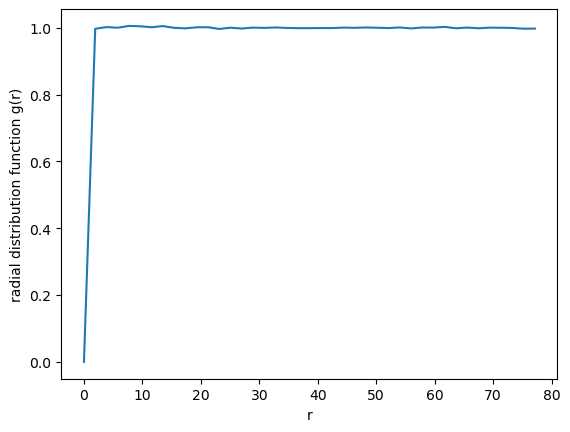

In [70]:
plt.plot(r, gr_avg)
plt.xlabel("r")
plt.ylabel("radial distribution function g(r)")
print(gr)

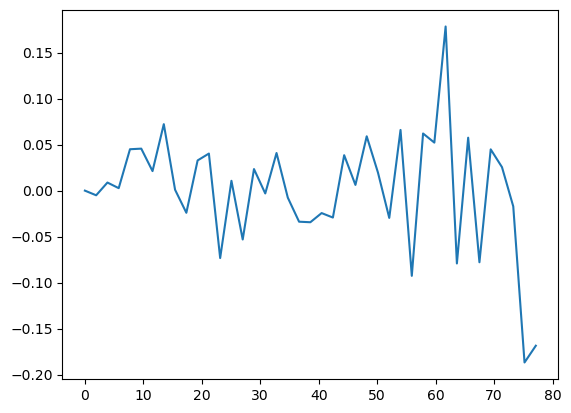

In [71]:
plt.plot(r, r*(gr_avg-1))

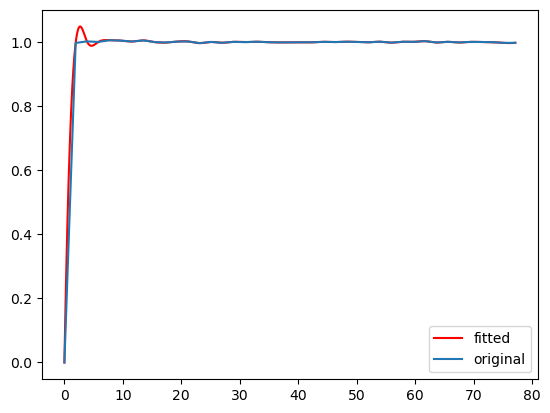

In [72]:
r_fit, g_fit = helper.g_fit(r, gr_avg)
plt.plot(r_fit, g_fit, 'r-', label="fitted")
plt.plot(r, gr_avg, label="original")
plt.legend()

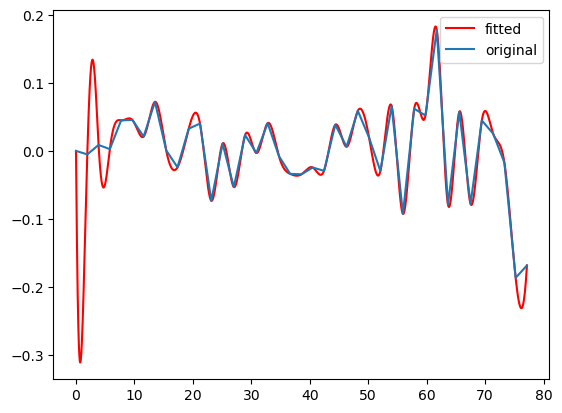

In [73]:
plt.plot(r_fit, r_fit*(g_fit-1), 'r-', label="fitted")
plt.plot(r, r*(gr_avg-1), label="original")
plt.legend()

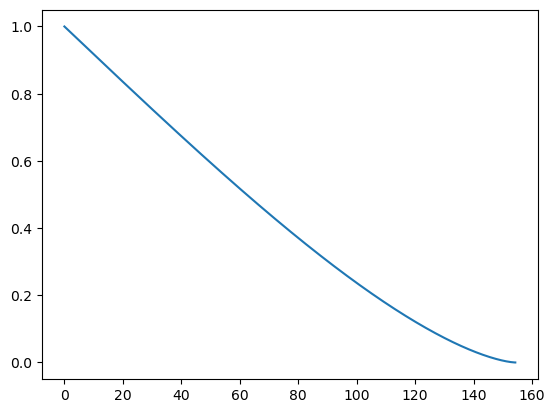

In [74]:
def window_intersection(r, radius):
    return 2/np.pi*(np.acos(r/(2*radius))-r/(2*radius)*(1-r**2/(4*radius**2))**0.5)

x = np.linspace(0, box_length, 1000)
y = window_intersection(x, box_length/2)
plt.plot(x,y)

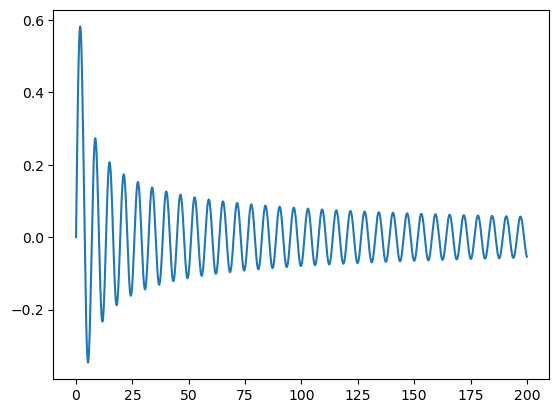

In [75]:
x = np.linspace(0, 200, 10001)
y = j1(x)

plt.plot(x, y)

-0.015437439930564947


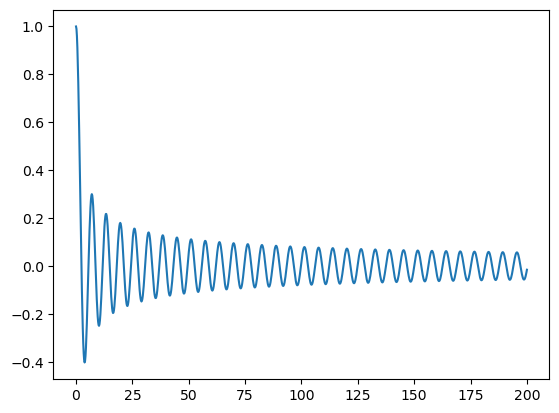

In [76]:
x = np.linspace(0, 200, 1000)
y = j0(x)

plt.plot(x, y)
print(y[-1])

[8.14557775e-02 8.14756496e-02 8.14955314e-02 ... 1.11322896e+02
 1.66984344e+02 3.33968688e+02] [0.76330393 0.76326091 0.76321838 ... 1.0000452  1.00005205 0.98743014]


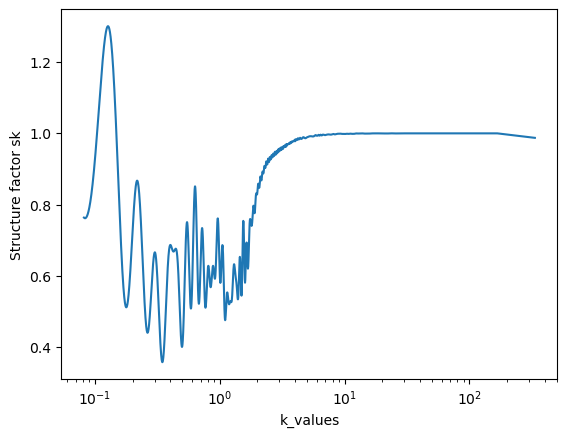

In [77]:
k_values = np.sort(2*np.pi/r_fit[1:])
sk = helper.hankel_transform_2d(g_fit, r_fit, k_values)
plt.plot(k_values, sk)
plt.xscale('log')
plt.xlabel("k_values")
plt.ylabel("Structure factor sk")
print(k_values, sk)

In [78]:
variance_square=helper.variance_calculation_in_real_space(r_fit, g_fit)
print(variance_square)

3885.8329490985952


In [79]:
variance_square = helper.variance_calculations_in_reciprocal_space_2d(sk, k_values)
print(variance_square)

303.05632215217884


In [80]:
def particles_in_windows_real_variances(positions, origin1, radius):
    return np.sum(np.linalg.norm(positions-origin1, axis=1)<radius)
x_range = np.linspace(-1/8, 1/8, 1001)*box_length
y_range = np.linspace(-1/8, 1/8, 1001)*box_length
num_particles = np.zeros(1001)
for i in range(len(x_range)):
    particles = (particles_in_windows_real_variances(data[1:], origin1=np.array([x_range[i], y_range[i], 0]), radius=3*box_length/8))
    num_particles[i] = particles
print(num_particles)
print(np.mean(num_particles))
print(num_particles-np.mean(num_particles))
print(np.average((num_particles-np.mean(num_particles))**2))

[2176. 2175. 2178. ... 2230. 2230. 2232.]
2197.5344655344657
[-21.53446553 -22.53446553 -19.53446553 ...  32.46553447  32.46553447
  34.46553447]
232.65640453452647
